<a href="https://colab.research.google.com/github/Ehat825/Ehat825.github.io/blob/main/Image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision import models
import torchvision.transforms as T
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F

transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])
target_transform = T.Compose([
    T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
    T.PILToTensor()
])

train_dataset = VOCSegmentation(root='path/to/data', year='2012', image_set='train', download=True,
                                 transform=transform, target_transform=target_transform)
test_dataset = VOCSegmentation(root='path/to/data', year='2012', image_set='val', download=True,
                                transform=transform, target_transform=target_transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


100%|██████████| 2.00G/2.00G [02:43<00:00, 12.2MB/s]


In [2]:
class ResNetSegmentation(nn.Module):
    def __init__(self, num_classes=21):
        super(ResNetSegmentation, self).__init__()
        resnet = models.resnet50(pretrained=True)

        # Encoder layers
        self.conv1 = resnet.conv1      # 64 channels, output size: input/2
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool  # output size: input/4

        self.layer1 = resnet.layer1    # 256 channels, output size: input/4
        self.layer2 = resnet.layer2    # 512 channels, output size: input/8
        self.layer3 = resnet.layer3    # 1024 channels, output size: input/16
        self.layer4 = resnet.layer4    # 2048 channels, output size: input/32

        # Decoder layers with skip connections
        self.up1 = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )  # output: 512 channels, size: input/16

        self.up2 = nn.Sequential(
            nn.Conv2d(512 + 1024, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )  # output: 256 channels, size: input/8

        self.up3 = nn.Sequential(
            nn.Conv2d(256 + 512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )  # output: 128 channels, size: input/4

        self.up4 = nn.Sequential(
            nn.Conv2d(128 + 256, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )  # output: 64 channels, size: input/2

        self.up5 = nn.Sequential(
            nn.Conv2d(64 + 64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )  # output: 32 channels, size: input size

        # Final classification layer
        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        # Store input size for potential final adjustment
        input_size = x.size()[2:]

        # Encoder path with feature extraction at each level
        x1 = self.relu(self.bn1(self.conv1(x)))       # size: input/2
        x2 = self.maxpool(x1)                         # size: input/4
        x2 = self.layer1(x2)                          # size: input/4
        x3 = self.layer2(x2)                          # size: input/8
        x4 = self.layer3(x3)                          # size: input/16
        x5 = self.layer4(x4)                          # size: input/32

        # Decoder path with skip connections
        p5 = self.up1(x5)                             # size: input/16
        p4 = self.up2(torch.cat([p5, x4], dim=1))     # size: input/8
        p3 = self.up3(torch.cat([p4, x3], dim=1))     # size: input/4
        p2 = self.up4(torch.cat([p3, x2], dim=1))     # size: input/2
        p1 = self.up5(torch.cat([p2, x1], dim=1))     # size: same as input


        # Ensure output logits are reasonable
        logits = self.classifier(p1)

        # Optional: Apply log_softmax instead of raw logits
        logits = F.log_softmax(logits, dim=1)


        # Add this extra check to ensure output size exactly matches input size
        if logits.size()[2:] != input_size:
            logits = nn.functional.interpolate(logits, size=input_size,
                                             mode='bilinear', align_corners=True)

        return logits

# Create model
model = ResNetSegmentation(num_classes=21)

class BasicResNetSegmentation(nn.Module):
    def __init__(self, num_classes=21):
        super(ResNetSegmentation, self).__init__()
        resnet = models.resnet50(pretrained=True)

        # Use all layers except the last FC and avgpool
        self.encoder = nn.Sequential(
            resnet.conv1,  # 64
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,  # 256
            resnet.layer2,  # 512
            resnet.layer3,  # 1024
            resnet.layer4   # 2048
        )

        # Decoder: 1x1 convolution to reduce channels to num_classes
        self.classifier = nn.Conv2d(2048, num_classes, kernel_size=1)

        # Bilinear upsampling to input image size
        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)

    def forward(self, x):
        input_size = x.shape[2:]  # (H, W)
        x = self.encoder(x)
        x = self.classifier(x)
        x = nn.functional.interpolate(x, size=input_size, mode='bilinear', align_corners=False)
        return x

# Create model
model = ResNetSegmentation(num_classes=21)
print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 144MB/s]


ResNetSegmentation(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1),

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetSegmentation(num_classes=21).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 20

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    total_train_loss = 0

    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.squeeze(1).long().to(device)

        outputs = model(imgs)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validation ----
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs = imgs.to(device)
            masks = masks.squeeze(1).long().to(device)

            outputs = model(imgs)
            loss = criterion(outputs, masks)

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")




Epoch 1/20 - Train Loss: 2.6790 - Val Loss: 2.3829
Epoch 2/20 - Train Loss: 2.2141 - Val Loss: 1.9690
Epoch 3/20 - Train Loss: 1.8465 - Val Loss: 1.7465
Epoch 4/20 - Train Loss: 1.5204 - Val Loss: 1.4499
Epoch 5/20 - Train Loss: 1.2397 - Val Loss: 1.2688
Epoch 6/20 - Train Loss: 0.9751 - Val Loss: 1.0987
Epoch 7/20 - Train Loss: 0.7739 - Val Loss: 0.8431
Epoch 8/20 - Train Loss: 0.6226 - Val Loss: 0.7187
Epoch 9/20 - Train Loss: 0.5196 - Val Loss: 0.6758
Epoch 10/20 - Train Loss: 0.4331 - Val Loss: 0.5954
Epoch 11/20 - Train Loss: 0.3697 - Val Loss: 0.5772
Epoch 12/20 - Train Loss: 0.3345 - Val Loss: 0.5771
Epoch 13/20 - Train Loss: 0.3343 - Val Loss: 0.5577
Epoch 14/20 - Train Loss: 0.2915 - Val Loss: 0.5239
Epoch 15/20 - Train Loss: 0.2329 - Val Loss: 0.5164
Epoch 16/20 - Train Loss: 0.2004 - Val Loss: 0.4762
Epoch 17/20 - Train Loss: 0.1995 - Val Loss: 0.4933
Epoch 18/20 - Train Loss: 0.1677 - Val Loss: 0.4932
Epoch 19/20 - Train Loss: 0.1651 - Val Loss: 0.4962
Epoch 20/20 - Train L

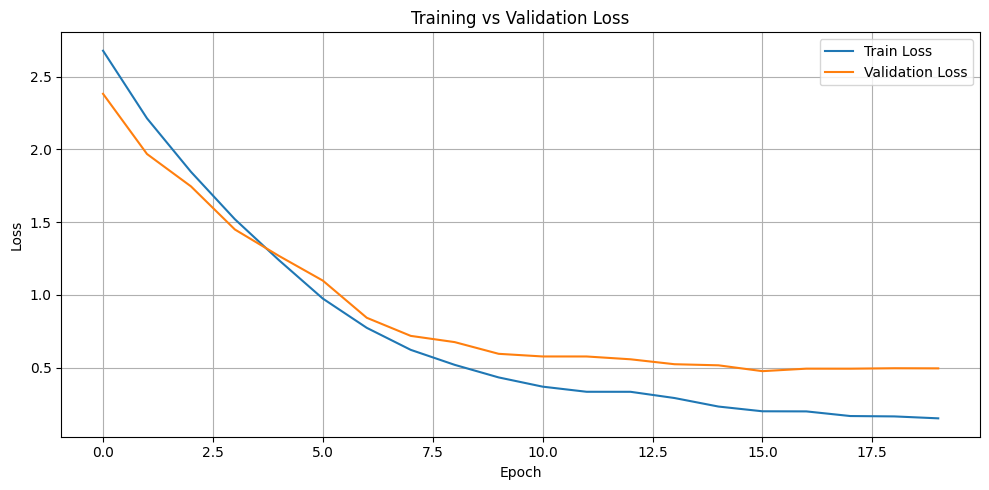

In [4]:
import matplotlib.pyplot as plt

# ---- Plotting ----
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

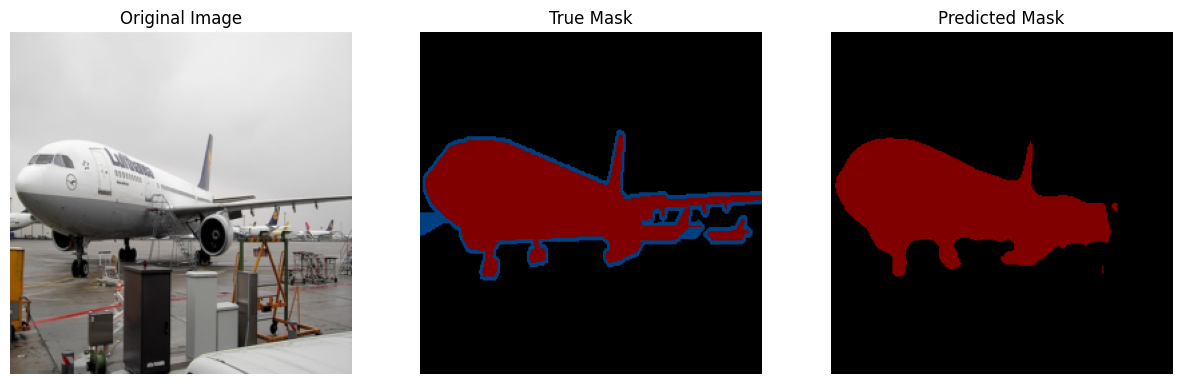

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Function to display multiclass segmentation masks
def visualize_segmentation(image, true_mask, pred_mask, class_colors=None, num_classes=21):
    # Move data back to CPU for visualization
    image = image.cpu()
    true_mask = true_mask.cpu().squeeze()  # Remove extra dimension
    pred_mask = pred_mask.cpu().squeeze()

    # Debug: Print shape and value range
    if len(pred_mask.shape) > 2:
        print(f"Pred mask shape before argmax: {pred_mask.shape}")
        print(f"Pred mask min/max values: {pred_mask.min().item()}, {pred_mask.max().item()}")

        # Convert to class indices
        pred_mask = torch.argmax(pred_mask, dim=0).numpy()

        # Check the range of indices
        print(f"Unique class indices in prediction: {np.unique(pred_mask)}")
    else:
        pred_mask = pred_mask.numpy()

    # Ensure pred_mask values are within valid range
    if pred_mask.max() >= num_classes:
        print(f"WARNING: Prediction contains invalid class indices (max={pred_mask.max()})")
        pred_mask = np.clip(pred_mask, 0, num_classes-1)

    # Convert true_mask to numpy
    true_mask = true_mask.numpy()

    # Create a colormap for visualization if not provided
    if class_colors is None:
        # Generate a colormap (excluding black for better visibility)
        colors = plt.cm.jet(np.linspace(0, 1, num_classes))
        class_colors = ListedColormap(colors)

    # Display the original image, the true mask, and the predicted mask
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap=class_colors, vmin=0, vmax=num_classes-1)
    plt.title("True Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap=class_colors, vmin=0, vmax=num_classes-1)
    plt.title("Predicted Mask")
    plt.axis('off')



    #plt.tight_layout()
    plt.show()

# For VOC dataset, you can define specific colors for each class
def get_pascal_voc_colormap():
    """Returns the PASCAL VOC colormap for visualization"""
    colormap = np.zeros((21, 3), dtype=np.uint8)
    colormap[0] = [0, 0, 0]        # background
    colormap[1] = [128, 0, 0]      # aeroplane
    colormap[2] = [0, 128, 0]      # bicycle
    colormap[3] = [128, 128, 0]    # bird
    colormap[4] = [0, 0, 128]      # boat
    colormap[5] = [128, 0, 128]    # bottle
    colormap[6] = [0, 128, 128]    # bus
    colormap[7] = [128, 128, 128]  # car
    colormap[8] = [64, 0, 0]       # cat
    colormap[9] = [192, 0, 0]      # chair
    colormap[10] = [64, 128, 0]    # cow
    colormap[11] = [192, 128, 0]   # diningtable
    colormap[12] = [64, 0, 128]    # dog
    colormap[13] = [192, 0, 128]   # horse
    colormap[14] = [64, 128, 128]  # motorbike
    colormap[15] = [192, 128, 128] # person
    colormap[16] = [0, 64, 0]      # pottedplant
    colormap[17] = [128, 64, 0]    # sheep
    colormap[18] = [0, 192, 0]     # sofa
    colormap[19] = [128, 192, 0]   # train
    colormap[20] = [0, 64, 128]    # tvmonitor

    return ListedColormap(colormap / 255.0)

# Get a batch of data from your data loader
for imgs, masks in test_loader:
    image, mask = imgs[0], masks[0]  # Get the first image and mask from the batch
    break  # Stop after getting one image

# Move image to the appropriate device (e.g., CUDA)
image = image.to(device)

# Get the model's prediction
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = model(image.unsqueeze(0))  # Add batch dimension
    predicted_mask = outputs.softmax(dim=1)  # Apply softmax to get probabilities
    predicted_mask = predicted_mask.argmax(dim=1)  # Get class indices


# Visualize the segmentation results
voc_cmap = get_pascal_voc_colormap()
visualize_segmentation(image, mask, predicted_mask, class_colors=voc_cmap, num_classes=21)